# Burnup with material extraction
Burn materials and then extract the burned materials from results tally. First iteration 12 NOV 2022.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et

## Create Materials

In [2]:
# fuel uranium dioxode (PNNL)
fuel = openmc.Material(name='uo2')
fuel.set_density('g/cc',10.96)
fuel.add_nuclide('U234', 0.000090, 'ao')
fuel.add_nuclide('U235', 0.010124, 'ao')
fuel.add_nuclide('U236', 0.000046, 'ao')
fuel.add_nuclide('U238', 0.323072, 'ao')
fuel.add_element('O', 0.666667, 'ao')
#fuel.remove_nuclide('O17')
fuel.depletable = True

clad = openmc.Material(name='Zirc4')
clad.set_density('g/cc', 6.56)
clad.add_element('O', 0.006790, 'ao')
clad.add_element('Cr', 0.001741, 'ao')
clad.add_element('Fe', 0.003242, 'ao')
clad.add_element('Zr', 0.977549, 'ao')
clad.add_element('Sn', 0.010677, 'ao')
# clad.add_nuclide('U235', 0.010124e-19, 'ao')
# clad.remove_nuclide('O17')
# clad.depletable = True

water = openmc.Material(name='h2o')
water.set_density('g/cc', 0.712)
water.add_element('H', 2)
water.add_element('O', 1)
#water.remove_nuclide('O17')
water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([fuel, clad, water])
materials.export_to_xml()

## Create Geometry
pincell geometry modeling internal PWR location

In [3]:
h_cell = 300; # height of pincell

r_fuel = 0.42; # fuel radius
r_pin = 0.45; # clad radius

P_D = 1.4; # pitch to diameter ratio
pitch = P_D*(2*r_pin);

fuel_temp = 900; # representaive fuel temperature (K)
mod_temp = 600; # moderator temp (K)

# fuel cylinder
fuel_cyl = openmc.model.RightCircularCylinder([0,0,-h_cell/2],h_cell,r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_cell;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0,0,-(h_cell+(r_pin-r_fuel))/2],h_cell+(r_pin-r_fuel)*2,r_pin);

clad.volume = np.pi*((r_pin**2) - (r_fuel**2))*h_cell;

# pin cell container

core_cell = openmc.model.RectangularParallelepiped(-pitch/2,pitch/2,
                                                   -pitch/2,pitch/2,
                                                   -(h_cell+100)/2,(h_cell+100)/2,
                                                   boundary_type = "reflective");
fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;

clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & - core_cell;
mod_cell.fill = water;
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

geometry.export_to_xml();

## Create Criticality Settings

In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 250;
settings.inactive = 50;

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_cell/2),
                      upper_right = (r_fuel,r_fuel,h_cell/2),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;
settings.temperature['method']='interpolation';
settings.export_to_xml();

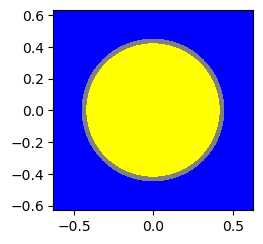

In [5]:
# create color dictionary
colors = {}
colors[water]='blue';
colors[fuel]='yellow';
colors[clad]='gray';

# plot pin cell universe to inspect geometry
root_univ.plot(width=(pitch,pitch),color_by='material',colors=colors);

## Conduct Depletion

In [6]:
model = openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_pwr.xml");

# typical PWR power density
power_density = [30.5,30.5,30.5,30.5,30.5,
                30.5,30.5,30.5,30.5,30.5,
                0,0,0,0,0]; # power density W/gHM 
# power 0 after 4.5 years with cooldown steps of a day, week, month to 2 years
days = 24*3600;
time_steps = [0.5*days,0.5*days,1*days,5*days,
              23*days,150*days,365*days,365*days,
              365*days,365*days,
              1*days,6*days,23*days,335*days,365*days];
cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);

repeat_depletion = False


if(repeat_depletion):
    cecm.integrate()

In [7]:
# get depletion results to manipulate
r = openmc.deplete.Results('depletion_results.h5')
burned_mats = r.export_to_materials(burnup_index=15) #consider adding this once updated version maybe  ,path='burnedmats15.xml'
burned_mats.export_to_xml('BurnedMaterials15.xml')

In [8]:
print(burned_mats)

[Material
	ID             =	1
	Name           =	uo2
	Temperature    =	None
	Density        =	10.96 [sum]
	Volume         =	166.25308322797184 [cm^3]
	S(a,b) Tables  
	Nuclides       
	Ac225          =	1.3404408545360322e-19 [ao]
	Ac226          =	1.1534678985459101e-35 [ao]
	Ac227          =	8.682192962559074e-16 [ao]
	Ag107          =	9.765571309823805e-12 [ao]
	Ag109          =	7.86759183327813e-06 [ao]
	Ag110_m1       =	1.4463333074538023e-08 [ao]
	Ag111          =	8.224734488299838e-38 [ao]
	Al27           =	9.993077729917787e-22 [ao]
	Am240          =	3.0027917522892744e-27 [ao]
	Am241          =	6.118181493753402e-06 [ao]
	Am242          =	2.8403849405163825e-13 [ao]
	Am242_m1       =	2.2015455694568603e-08 [ao]
	Am243          =	8.155497126861068e-06 [ao]
	Am244          =	7.741811805268526e-22 [ao]
	Ar36           =	9.797601223836429e-22 [ao]
	Ar38           =	9.987391666081973e-22 [ao]
	Ar40           =	1.009999824617159e-21 [ao]
	As74           =	1.083088534156887e-27 [ao]
	A

In [9]:
mat_tree = et.parse('BurnedMaterials15.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='uo2':
        uo2_elem = root[i]
    i+=1

In [10]:
# create Material object from element in burned Materials object
uo2_elem.set('id',23)
print(uo2_elem.items())
type(uo2_elem)
burned_uo2 = openmc.Material.from_xml_element(uo2_elem)
burned_uo2_mass = burned_uo2.get_mass()

#burned_uo2 = openmc.Material(name='burned_uo2')
#Burned_uo2 = burned_uo2.from_xml_element(uo2_elem)
print(burned_uo2)
print(burned_uo2_mass)

[('depletable', 'true'), ('id', 23), ('name', 'uo2'), ('volume', '166.25308322797184')]
Material
	ID             =	23
	Name           =	uo2
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	166.25308322797184 [cm^3]
	S(a,b) Tables  
	Nuclides       
	Ac225          =	1.3404408545360322e-19 [ao]
	Ac226          =	1.1534678985459101e-35 [ao]
	Ac227          =	8.682192962559074e-16 [ao]
	Ag107          =	9.765571309823805e-12 [ao]
	Ag109          =	7.86759183327813e-06 [ao]
	Ag110_m1       =	1.4463333074538023e-08 [ao]
	Ag111          =	8.224734488299838e-38 [ao]
	Al27           =	9.993077729917787e-22 [ao]
	Am240          =	3.0027917522892744e-27 [ao]
	Am241          =	6.118181493753402e-06 [ao]
	Am242          =	2.8403849405163825e-13 [ao]
	Am242_m1       =	2.2015455694568603e-08 [ao]
	Am243          =	8.155497126861068e-06 [ao]
	Am244          =	7.741811805268526e-22 [ao]
	Ar36           =	9.797601223836429e-22 [ao]
	Ar38           =	9.987391666081973e-22 [ao]
	Ar40

In [11]:
listnuc = burned_uo2.get_nuclides() # list of nuclides present in burned fuel

In [12]:
# get string with all Pu isotopes present in burned fuel
# isotopes that will be present after chemical processing
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)
        
        

In [13]:
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_uo2.get_mass(nuclide=nuclide)
print(pu_mass)

21.346540636569266


In [14]:
pu_mass_fraction = pu_mass/burned_uo2_mass
print(pu_mass_fraction)

0.011716170261881594


In [15]:
# create metallic Pu from separated Pu product in Burned Fuel
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium

print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_uo2.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1
print(BurnPuAo)
print(SepPu)


['Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244', 'Pu246']
[OrderedDict([('Pu236', 7.080765161448044e-14)]), OrderedDict([('Pu237', 5.4777687651029544e-17)]), OrderedDict([('Pu238', 1.1948565051716036e-05)]), OrderedDict([('Pu239', 0.00015657775605235075)]), OrderedDict([('Pu240', 7.933476237079491e-05)]), OrderedDict([('Pu241', 4.440768557715209e-05)]), OrderedDict([('Pu242', 3.0150063521968756e-05)]), OrderedDict([('Pu243', 5.2446512856564556e-20)]), OrderedDict([('Pu244', 3.784017680007784e-09)]), OrderedDict([('Pu246', 1.3291659596292555e-23)])]
Material
	ID             =	4
	Name           =	PuProduct
	Temperature    =	None
	Density        =	19.84 [g/cc]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	Nuclides       
	Pu236          =	7.080765161448044e-14 [ao]
	Pu237          =	5.4777687651029544e-17 [ao]
	Pu238          =	1.1948565051716036e-05 [ao]
	Pu239          =	0.00015657775605235075 [ao]
	Pu240          =	7.933476237079491e-05 [ao]
	Pu241   

## Conduct BCM search

In [16]:
def build_model(radius, fuel):
    
    
    materials = openmc.Materials([fuel])
    
    # create sphere with radius parameter
    sphere_radius = openmc.Sphere(x0=0,y0=0,z0=0,r=radius, boundary_type='vacuum', name='BCM')
    
    # create core cell
    core_cell = openmc.Cell(name='Bare Critical Sphere')
    core_cell.fill = fuel
    core_cell.region = -sphere_radius
    
    # create universe geometry
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([core_cell])
    
    geometry = openmc.Geometry(root_universe)
    # define criticality settings
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue' # keff calculation
    settings.particles = 5000 # particles per batch (mo betta)
    settings.batches = 250 # number of batches
    settings.inactive = 50 # inactive batches
    
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry,materials,settings)
    
    return model

In [17]:
crit_r, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1,50],model_args={'fuel':SepPu},
                                                tol=1e-4, print_iterations=True,
                                               run_args={'output':False})
# print results and collect data
print('Burned Plutonium Critical Mass')
print('The bare critical sphere radius is %7.4f cm.' % crit_r)
crit_v = 4/3*pi*crit_r**3 # volume of critical sphere (cc)

BCM = crit_v * 19.84 /1000 # mass of critical radius (kg)
print('The bare critical mass is %7.3f kg.' % BCM)

BCMs = np.array(BCM)
print(BCMs,
      '\n')

Iteration: 1; Guess of 1.00e+00 produced a keff of 0.19827 +/- 0.00014
Iteration: 2; Guess of 5.00e+01 produced a keff of 2.71799 +/- 0.00080
Iteration: 3; Guess of 2.55e+01 produced a keff of 2.42595 +/- 0.00111
Iteration: 4; Guess of 1.32e+01 produced a keff of 1.86293 +/- 0.00108
Iteration: 5; Guess of 7.12e+00 produced a keff of 1.22457 +/- 0.00077
Iteration: 6; Guess of 4.06e+00 produced a keff of 0.75818 +/- 0.00053
Iteration: 7; Guess of 5.59e+00 produced a keff of 1.00406 +/- 0.00066
Iteration: 8; Guess of 4.83e+00 produced a keff of 0.88313 +/- 0.00057
Iteration: 9; Guess of 5.21e+00 produced a keff of 0.94551 +/- 0.00061
Iteration: 10; Guess of 5.40e+00 produced a keff of 0.97361 +/- 0.00069
Iteration: 11; Guess of 5.50e+00 produced a keff of 0.98991 +/- 0.00063
Iteration: 12; Guess of 5.55e+00 produced a keff of 0.99696 +/- 0.00065
Iteration: 13; Guess of 5.57e+00 produced a keff of 1.00013 +/- 0.00066
Iteration: 14; Guess of 5.56e+00 produced a keff of 0.99872 +/- 0.00067
I

In [18]:
net_weight_LEU = BCM/pu_mass_fraction
print(net_weight_LEU,' kg') # in kg only fuel material (no clad)

1223.4375338657883  kg


In [19]:
# get activity from burned fuel
print('Target material activity is %5.3g Bq/g ' % burned_uo2.get_activity())
burnact = burned_uo2.get_activity(by_nuclide=True,units='Bq/g')
print(burnact)

Target material activity is 4.59e+11 Bq/g 
{'Ac225': 0.009812671329510619, 'Ac226': 6.9000526449926814e-18, 'Ac227': 0.0799245978038691, 'Ag107': 0.0, 'Ag109': 0.0, 'Ag110_m1': 42392124.215230405, 'Ag111': 8.081746257755773e-21, 'Al27': 0.0, 'Am240': 1.0385139637497923e-09, 'Am241': 28345608.07215067, 'Am242': 311505.36295729893, 'Am242_m1': 312937.7095918649, 'Am243': 2217846.1282840827, 'Am244': 0.0013467037655476844, 'Ar36': 0.0, 'Ar38': 0.0, 'Ar40': 0.0, 'As74': 4.461861929989679e-11, 'As75': 0.0, 'Au197': 0.0, 'B10': 0.0, 'B11': 0.0, 'Ba130': 0.0, 'Ba132': 0.0, 'Ba133': 5324.975882872278, 'Ba134': 0.0, 'Ba135': 0.0, 'Ba136': 0.0, 'Ba137': 0.0, 'Ba138': 0.0, 'Ba140': 2.723767921250327e-07, 'Bi209': 2.2655343064274095e-21, 'Bk246': 7.106694724220874e-106, 'Bk247': 3.837029319365761e-08, 'Bk248': 0.0013465313860716018, 'Bk249': 1027.9045810303198, 'Bk250': 0.0033781892214599252, 'Br79': 0.0, 'Br81': 0.0, 'Ca40': 0.0, 'Ca42': 0.0, 'Ca43': 0.0, 'Ca44': 0.0, 'Ca46': 0.0, 'Ca48': 8.68345

newburnact 10
burnact 400


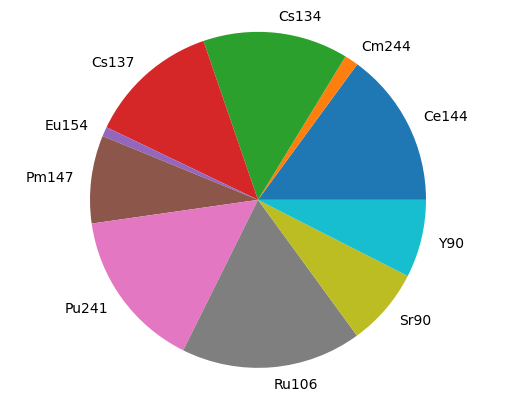

{'Ce144': 6039820752.850392, 'Cm244': 541486615.3170046, 'Cs134': 5650944754.321375, 'Cs137': 5101933117.074408, 'Eu154': 372034882.17443186, 'Pm147': 3415856817.5526543, 'Pu241': 6228382653.018819, 'Ru106': 7016975662.415062, 'Sr90': 3026695954.7046375, 'Y90': 3027463697.567163}


In [20]:
# plot activities in pie chart
# end of cool down period (2 years)

#newBurnact = burnact.copy()
newBurnact = {}
thresh = 3.7e8
for i, j in burnact.items():
        if j >= thresh:
                newBurnact[i] = j



labels = []
sizes = []
for x, y in newBurnact.items():
    labels.append(x)
    sizes.append(y)
    
print('newburnact',len(newBurnact))
print('burnact',len(burnact)) 
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()
print(newBurnact)

In [21]:
# fuel uranium dioxode (PNNL)
fuel = openmc.Material(name='uo2')
fuel.set_density('g/cc',10.96)
fuel.add_nuclide('U234', 0.000090, 'ao')
fuel.add_nuclide('U235', 0.010124, 'ao')
fuel.add_nuclide('U236', 0.000046, 'ao')
fuel.add_nuclide('U238', 0.323072, 'ao')
fuel.add_element('O', 0.666667, 'ao')

clad = openmc.Material(name='Zirc4')
clad.set_density('g/cc', 6.56)
clad.add_element('O', 0.006790, 'ao')
clad.add_element('Cr', 0.001741, 'ao')
clad.add_element('Fe', 0.003242, 'ao')
clad.add_element('Zr', 0.977549, 'ao')
clad.add_element('Sn', 0.010677, 'ao')

water = openmc.Material(name='h2o')
water.set_density('g/cc', 0.712)
water.add_element('H', 2)
water.add_element('O', 1)
water.add_s_alpha_beta('c_H_in_H2O')

materials = openmc.Materials([fuel, clad, water])
materials.export_to_xml()

In [22]:
### Unsure this is working for the alternative Time step


## get activity at end of power cycle at start of cooldown
#burned_mats10 = r.export_to_materials(burnup_index=10)
#burned_mats10.export_to_xml('BurnedMaterials10.xml')
#print(burned_mats10)
#mat_tree2 = et.parse('BurnedMaterials10.xml')
#root2 = mat_tree2.getroot()
#i=0
#for child in root:
#    if child.attrib['name']=='uo2':
#        uo2_elem2 = root2[i]
#    i+=1
#    
#uo2_elem2.set('id',23+1)
#burned_uo210 = openmc.Material.from_xml_element(uo2_elem2)
#
#print('Target material activity is %5.3g Bq/g ' % burned_uo210.get_activity())
#burnact2 = burned_uo210.get_activity(by_nuclide=True,units='Bq/g')
#print(burnact2)
#labels2 = []
#sizes2 = []
#for x, y in burnact2.items():
#    labels2.append(x)
#    sizes2.append(y)
#    
#plt.pie(sizes2, labels=labels2)
#plt.axis('equal')
#plt.show()

In [23]:
print(burnact)

{'Ac225': 0.009812671329510619, 'Ac226': 6.9000526449926814e-18, 'Ac227': 0.0799245978038691, 'Ag107': 0.0, 'Ag109': 0.0, 'Ag110_m1': 42392124.215230405, 'Ag111': 8.081746257755773e-21, 'Al27': 0.0, 'Am240': 1.0385139637497923e-09, 'Am241': 28345608.07215067, 'Am242': 311505.36295729893, 'Am242_m1': 312937.7095918649, 'Am243': 2217846.1282840827, 'Am244': 0.0013467037655476844, 'Ar36': 0.0, 'Ar38': 0.0, 'Ar40': 0.0, 'As74': 4.461861929989679e-11, 'As75': 0.0, 'Au197': 0.0, 'B10': 0.0, 'B11': 0.0, 'Ba130': 0.0, 'Ba132': 0.0, 'Ba133': 5324.975882872278, 'Ba134': 0.0, 'Ba135': 0.0, 'Ba136': 0.0, 'Ba137': 0.0, 'Ba138': 0.0, 'Ba140': 2.723767921250327e-07, 'Bi209': 2.2655343064274095e-21, 'Bk246': 7.106694724220874e-106, 'Bk247': 3.837029319365761e-08, 'Bk248': 0.0013465313860716018, 'Bk249': 1027.9045810303198, 'Bk250': 0.0033781892214599252, 'Br79': 0.0, 'Br81': 0.0, 'Ca40': 0.0, 'Ca42': 0.0, 'Ca43': 0.0, 'Ca44': 0.0, 'Ca46': 0.0, 'Ca48': 8.683452412675062e-26, 'Cd106': 0.0, 'Cd108': 0.0,

In [24]:
total_spec_act = sum(burnact.values()) # sum of the specific activity of each isotope (Bq/g)
print(total_spec_act,' Bq/g')

41838961670.822914  Bq/g


In [25]:
print(net_weight_LEU,' kg')

1223.4375338657883  kg


In [26]:
totalact = total_spec_act*net_weight_LEU/(3.7e7) # total activity from nuclear fuel required for one BCM (Ci)
print(totalact,' Ci')

1383442.0563799143  Ci


In [27]:
print('BurnedMaterials15.xml')

BurnedMaterials15.xml


In [40]:
# Mass of fuel required for a BCM and number of assemblies needed

pin_fuel_mass = np.pi*(r_fuel**2)*h_cell*fuel.density; # mass in grams
print('fuel mass of one pin',pin_fuel_mass,'g')


pin_clad_mass = (np.pi*((r_pin**2) - (r_fuel**2))*h_cell)*clad.density;
print('clad mass of one pin',pin_clad_mass,'g')

clad_to_fuel = pin_clad_mass/pin_fuel_mass

pin_total_mass = pin_clad_mass + pin_fuel_mass
print('total mass of one pin',pin_total_mass/1000,'kg')
assem_fuel_mass = pin_fuel_mass*264 # based on AP1000 with 264 pins per assembly
print('fuel mass of one assembly',assem_fuel_mass/1000,'kg')
assem_total_mass = pin_total_mass*264 # based on AP1000 with 264 pins per assembly
print('total mass of one assembly',assem_total_mass/1000,'kg')

fuel mass of one pin 1822.1337921785716 g
clad mass of one pin 161.36727833310923 g
total mass of one pin 1.983501070511681 kg
fuel mass of one assembly 481.04332113514295 kg
total mass of one assembly 523.6442826150837 kg


In [43]:
# total number of assemblies 
num_assem = net_weight_LEU/(assem_fuel_mass/1000); # net weight of fuel required for one BCM (kg) / fuel mass in one assembly (kg)
print('the number of assemblies required to gather the material for one BCM is',num_assem);
total_net_wt_of_assem = np.ceil(num_assem)*(assem_total_mass/1000); # mass of whole number assemblies needed for one BCM (kg)
print('mass of whole number assemblies needed for one BCM',total_net_wt_of_assem,'kg');

the number of assemblies required to gather the material for one BCM is 2.5433001147979337
mass of whole number assemblies needed for one BCM 1570.9328478452512 kg
